In [47]:
import numpy as np
import os.path as osp
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt
import random

In [48]:
import pickle

In [49]:
with open('data_100.pickle', 'rb') as lb:
    rdata = pickle.load(lb)
    edge_indexes,features,surf_filters,ys_slab,ys_space,ys_all = rdata

In [50]:
tmp = []
for item in features:
    tmp.append(item[:,-4:])
features = np.array(tmp)

In [51]:
features

array([[[10.3,  0. ,  0. ,  0. ],
        [10.3,  1. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ],
        ...,
        [10.3,  0. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ]],

       [[10.3,  0. ,  0. ,  0. ],
        [10.3,  1. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ],
        ...,
        [10.3,  0. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ]],

       [[10.3,  0. ,  0. ,  0. ],
        [10.3,  1. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ],
        ...,
        [10.3,  1. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ],
        [10.3,  0. ,  0. ,  0. ]],

       ...,

       [[ 8.3,  0. ,  0. ,  0. ],
        [ 8.3,  0. ,  0. ,  3. ],
        [ 8.3,  0. ,  0. ,  0. ],
        ...,
        [ 8.3,  0. ,  0. ,  3. ],
        [ 8.3,  0. ,  0. ,  0. ],
        [ 8.3,  0. ,  0. ,  0. ]],

       [[ 8.3,  0. ,  0. ,  0. ],
        [ 8.3,  0. ,  0. ,  4. ],
        [ 8.3,  0. ,  0. ,  0. ],
        .

In [52]:
data_list = []
for i in range(len(ys_all)):
    edge_index = torch.tensor(edge_indexes[i], dtype=torch.long)
    x = torch.tensor(features[i], dtype=torch.float)
    surf_filter = torch.tensor(surf_filters[i], dtype=torch.long)
    y = torch.tensor(ys_space[i], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, surf_filter=surf_filter, y=y)
    data_list.append(data)

In [53]:
in_channels = len(data_list[0].x[0])
in_channels

4

In [54]:
import torch.nn.functional as F
from torch_geometric.nn import CGConv

class Net(torch.nn.Module):
    def __init__(self, in_channels):
        super(Net, self).__init__()
        self.conv1 = CGConv(in_channels)
        self.conv2 = CGConv(in_channels)
        self.lin = torch.nn.Linear(in_channels, 1)
    
    def forward(self, data):
        x, edge_index, surf_filter = data.x, data.edge_index, data.surf_filter

        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = x * surf_filter.reshape(-1,1)
        x = torch.sum(x, dim=0) / torch.sum(surf_filter)
        y = self.lin(x)

        return y

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
import copy
data_list_ = data_list[269:288] # Pt_111
data_list_ = copy.deepcopy(data_list) # all

In [57]:
random.shuffle(data_list_)
train_list = data_list_[:int(len(data_list_)*0.67)]
test_list = data_list_[int(len(data_list_)*0.67):]

In [58]:
model = Net(in_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_list = []

In [59]:
def get_loss(model,data_list):
    totalloss = 0
    for data in data_list:
        data = data.to(device)
        out = model(data)
        loss = F.mse_loss(out, data.y) 
        totalloss += loss
    return totalloss/len(data_list)

In [60]:
def get_plot(model,data_list):
    y = []
    ypred = []
    for data in data_list:
        data = data.to(device)
        out = model(data)
        ypred.append(out)
        y.append(data.y)
    ypred = torch.tensor(ypred)
    y = torch.tensor(y)
    pp = np.linspace(min(y),max(y))
    plt.plot(y,ypred,'.')
    plt.plot(pp,pp)
    plt.show()

In [61]:
model.train()

for epoch in range(200):
    for data in train_list:
        optimizer.zero_grad()
        data = data.to(device)
        out = model.train()(data)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_list.append(get_loss(model.eval(),train_list))
    print('epoch %d RMSE :%f' % (epoch, loss_list[-1]**0.5))

epoch 0 RMSE :0.584049
epoch 1 RMSE :0.426862
epoch 2 RMSE :0.290454
epoch 3 RMSE :0.227497
epoch 4 RMSE :0.203445
epoch 5 RMSE :0.188253
epoch 6 RMSE :0.177267
epoch 7 RMSE :0.168331
epoch 8 RMSE :0.161020
epoch 9 RMSE :0.155395
epoch 10 RMSE :0.151533
epoch 11 RMSE :0.149334
epoch 12 RMSE :0.148454
epoch 13 RMSE :0.148356
epoch 14 RMSE :0.148419
epoch 15 RMSE :0.148074
epoch 16 RMSE :0.146906
epoch 17 RMSE :0.144716
epoch 18 RMSE :0.141548
epoch 19 RMSE :0.137678
epoch 20 RMSE :0.133526
epoch 21 RMSE :0.129531
epoch 22 RMSE :0.126013
epoch 23 RMSE :0.123105
epoch 24 RMSE :0.120788
epoch 25 RMSE :0.118948
epoch 26 RMSE :0.117454
epoch 27 RMSE :0.116186
epoch 28 RMSE :0.115062
epoch 29 RMSE :0.114027
epoch 30 RMSE :0.113049
epoch 31 RMSE :0.112110
epoch 32 RMSE :0.111198
epoch 33 RMSE :0.110308
epoch 34 RMSE :0.109433
epoch 35 RMSE :0.108570
epoch 36 RMSE :0.107715
epoch 37 RMSE :0.106864
epoch 38 RMSE :0.106017
epoch 39 RMSE :0.105169
epoch 40 RMSE :0.104321
epoch 41 RMSE :0.103468
ep

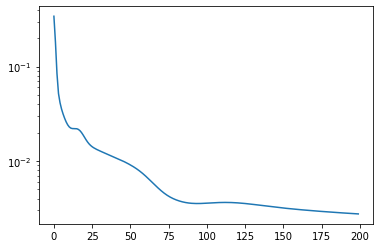

In [62]:
plt.plot(loss_list)
plt.yscale('log')
plt.show()

In [63]:
model.eval()

Net(
  (conv1): CGConv(4, dim=0)
  (conv2): CGConv(4, dim=0)
  (lin): Linear(in_features=4, out_features=1, bias=True)
)

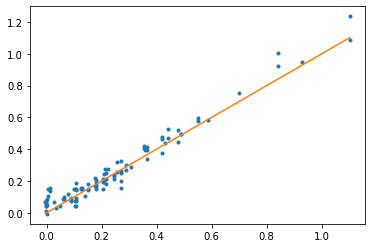

In [64]:
get_plot(model,train_list)

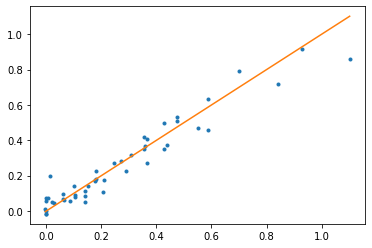

In [65]:
get_plot(model,test_list)

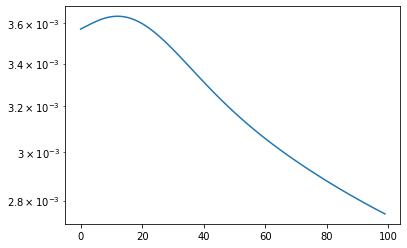

In [66]:
plt.plot(loss_list[-100:])
plt.yscale('log')
plt.show()

In [67]:
data_list_ = data_list[248:269] # Pt_100
get_plot(model,data_list_)

ValueError: min() arg is an empty sequence

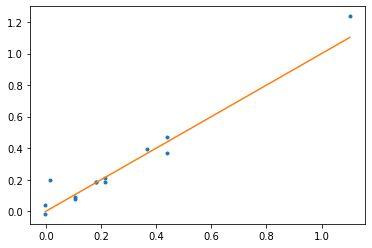

In [68]:
data_list_ = data_list[84:97] # Au_111
get_plot(model,data_list_)

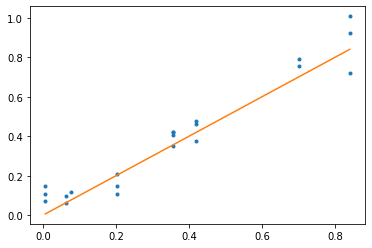

In [69]:
data_list_ = data_list[44:65] # Al_100
get_plot(model,data_list_)

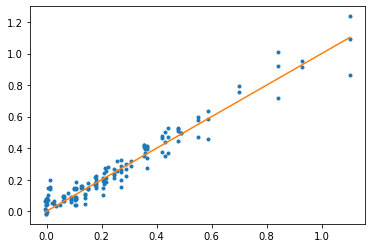

In [70]:
data_list_ = data_list # all
get_plot(model,data_list_)

In [71]:
loss_list[-1]**0.5

tensor(0.0524, device='cuda:0', grad_fn=<PowBackward0>)

In [72]:
get_loss(model,test_list)**0.5

tensor(0.0687, device='cuda:0', grad_fn=<PowBackward0>)

In [73]:
get_loss(model,data_list_)**0.5

tensor(0.0583, device='cuda:0', grad_fn=<PowBackward0>)